In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the modules directory to Python path
module_path = os.path.abspath(os.path.join('..', 'scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

#import modules
from scraper import main as run_scraper
from preprocessor import ReviewPreprocessor
from sentiment_analysis import BankReviewAnalyzer

In [2]:
print("[ Starting Scraper... ]")

# Run the main scraper function
raw_df = run_scraper()

print("\n[INFO] ------   Scraping Finished.   ------")
display(raw_df.head())

[ Starting Scraper... ]

===== Starting Google Play Store Review Scraper =====


[1/2] Fetching app information...

CBE: Commercial Bank of Ethiopia
App ID: com.combanketh.mobilebanking
Current Rating: 4.320868
Total Ratings: 38845
Total Reviews: 8334

BOA: Bank of Abissinia
App ID: com.boa.boaMobileBanking
Current Rating: 4.195008
Total Ratings: 6328
Total Reviews: 1219

DashenBank: Dashen Bank S.c.
App ID: com.dashen.dashensuperapp
Current Rating: 4.16962
Total Ratings: 3901
Total Reviews: 770

App information saved to data/raw/app_info.csv

[2/2] Scraping reviews...


Banks:   0%|          | 0/3 [00:00<?, ?it/s]

scraping reviews for: com.combanketh.mobilebanking ...
0 amount of data is scraped


Banks:  33%|███▎      | 1/3 [01:05<02:10, 65.16s/it]

scraping reviews for: com.boa.boaMobileBanking ...
0 amount of data is scraped


Banks:  67%|██████▋   | 2/3 [01:11<00:30, 30.38s/it]

scraping reviews for: com.dashen.dashensuperapp ...
0 amount of data is scraped


Banks: 100%|██████████| 3/3 [01:13<00:00, 24.42s/it]


ERROR: No reviews were collected!

[INFO] ------   Scraping Finished.   ------


""


In [3]:

preprocessor = ReviewPreprocessor()
success = preprocessor.process()

if success:
    print("\n Preprocessing finished successfully!")
    df = preprocessor.df
else:
    print(" Preprocessing failed.")

STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1260 reviews

[1/6] Checking for missing data...

Missing values:
  reply_content: 1258 (99.84%)
  app_id: 289 (22.94%)

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2024-09-14 to 2025-11-28

[4/6] Cleaning text...
Removed 35 reviews with empty text

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 1225 reviews

Saving processed data...
Data saved to: data/processed/reviews_processed.csv

PREPROCESSING REPORT

Original records: 1260
Records with missing critical data: 0
Empty reviews removed: 35
Invalid ratings removed: 0
Final records: 1225

Data retention rate: 97.22%
Data error rate: 2.78%
✓ Data quality: EXCELLENT (<5% errors)

Reviews per bank:
  Commercial Bank of Ethiopia: 411
  Bank of Abissinia: 407
  Dashen Bank S.c.: 407

Rating distribution:
  ⭐⭐⭐⭐⭐: 750 (61.2%)
  ⭐⭐⭐⭐: 91 (7.4%)
  ⭐⭐⭐: 69 (5.6%)
  ⭐⭐: 44 (3.6%)
  ⭐: 271 (22.1%)

Date ran

===== sentiment analysis started =====
Data loaded successfully: 1225 reviews
Found 3 banks: ['Bank of Abissinia', 'Commercial Bank of Ethiopia', 'Dashen Bank S.c.']
  - Bank of Abissinia: 407 reviews
  - Commercial Bank of Ethiopia: 411 reviews
  - Dashen Bank S.c.: 407 reviews
Preprocessing completed for combined: 1225 reviews
Preprocessing completed for Bank of Abissinia: 407 reviews
Preprocessing completed for Commercial Bank of Ethiopia: 411 reviews
Preprocessing completed for Dashen Bank S.c.: 407 reviews

ANALYZING: Bank of Abissinia

Basic Statistics for Bank of Abissinia:
  - Total Reviews: 407
  - Average Rating: 3.40
  - Sentiment Distribution: {'positive': 234, 'negative': 149, 'neutral': 24}

Top 10 frequent words for Bank of Abissinia:
  app: 155
  good: 64
  bank: 46
  boa: 31
  best: 31
  mobile: 27
  banking: 27
  work: 25
  use: 22
  worst: 21

Top 10 TF-IDF words for Bank of Abissinia:
  good: 0.1178
  app: 0.0756
  best: 0.0504
  nice: 0.0313
  boa: 0.0290
  bank: 0

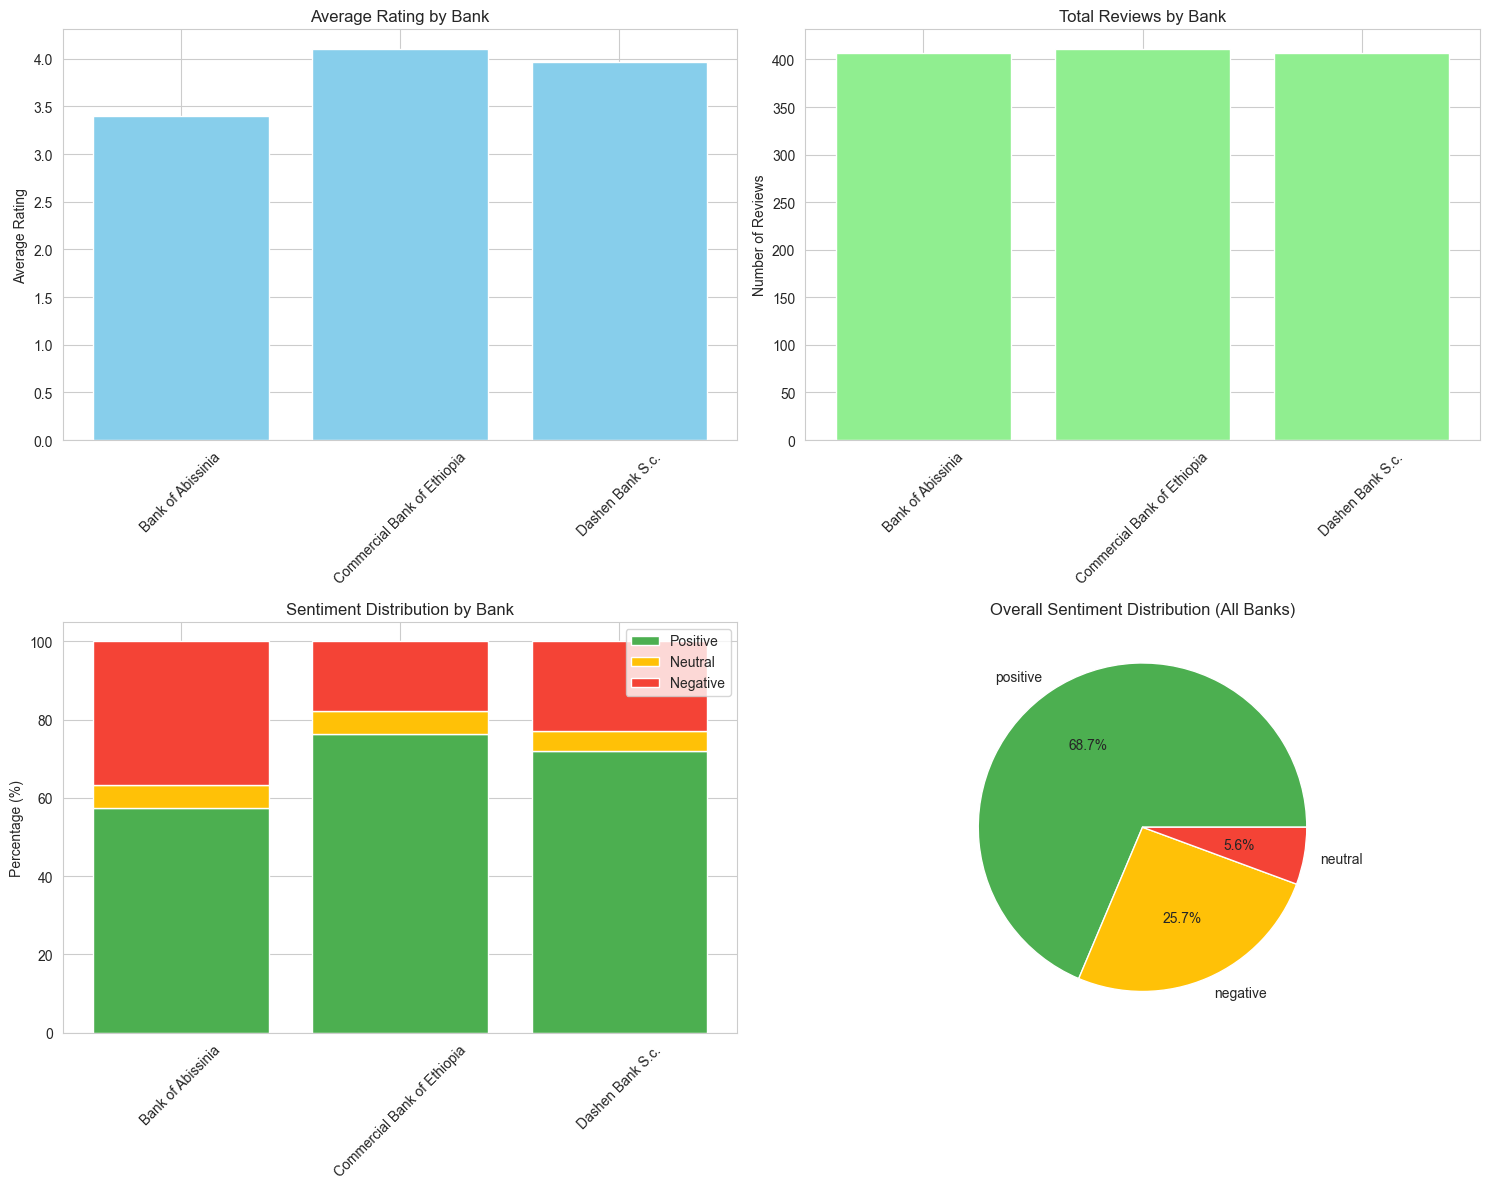

Report saved: bank_reports\bank_of_abissinia_analysis.csv
Report saved: bank_reports\commercial_bank_of_ethiopia_analysis.csv
Report saved: bank_reports\dashen_bank_s.c._analysis.csv

 sentiment analysis finished successfully!


In [4]:
print("===== sentiment analysis started =====")
analyzer=BankReviewAnalyzer()   #initializing
analyzer.run_complete_multi_bank_analysis('./data/processed/reviews_processed.csv')  #performing compleet analysis

if analyzer:
    print("\n sentiment analysis finished successfully!")
else:
    print("\n sentiment alalysis failed.")

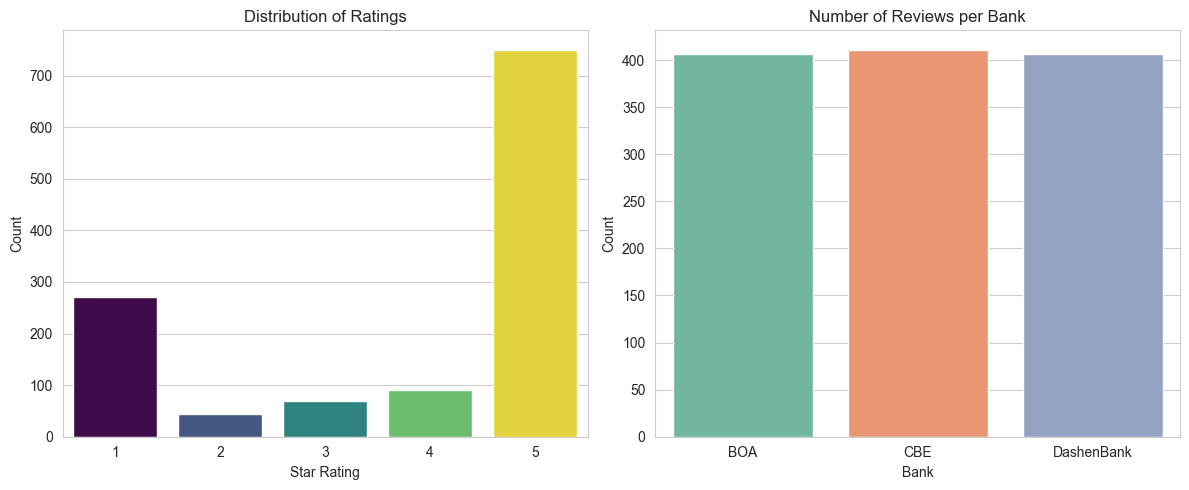

In [7]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# 1. Ratings Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=df, hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')

# 2. Reviews per Bank
plt.subplot(1, 2, 2)
sns.countplot(x='bank_code', data=df, hue='bank_code', palette='Set2', legend=False)
plt.title('Number of Reviews per Bank')
plt.xlabel('Bank')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

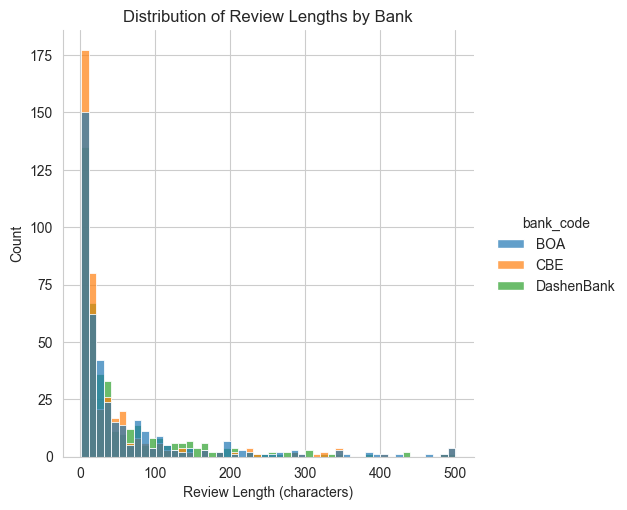

In [6]:
# 3. Review Length Distribution
plt.figure(figsize=(10, 6))
sns.displot(data=df, x='text_length', hue='bank_code', kind='hist', 
            bins=50, alpha=0.7, multiple="layer")
plt.title('Distribution of Review Lengths by Bank')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()